In [1]:
pip install scipy

In [2]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('leukemia.mat')

# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
print("X =",X)
print(X.shape[1])

X = [[-2  2  0 ...  2  0  0]
 [ 0  0  0 ...  0 -2  0]
 [-2 -2  0 ...  2  0  0]
 ...
 [ 2  2  0 ...  0  0  2]
 [ 0 -2  0 ...  0  0 -2]
 [ 2 -2  0 ...  0  0 -2]]
7070


In [3]:
# import scipy.io

# # Load the .mat file
# mat_contents = scipy.io.loadmat('leukemia.mat')

# # Display the contents
# #print(mat_contents)
# data = mat_contents
# X = data['X']
# print("X =",X)
# print(X.shape[1])

In [4]:
pip install pymoo

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from pymoo.indicators.hv import HV

In [6]:
X = data['X']
Y = data['Y'].flatten()

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [8]:
class FeatureSelectionProblem(Problem):

    def __init__(self,X,Y):
        super().__init__(n_var=X.shape[1], n_obj=2,n_constr=0, xl=0,  xu=1,  type_var=int)
        self.X = X
        self.Y = Y
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = []
        f2 = []
        
        for i in range(x.shape[0]):
            selected_features = np.where(x[i] == 1)[0]
            if len(selected_features) == 0:
                f1.append(1.0)
                f2.append(self.X.shape[1])
            else:
                X_selected = self.X[:, selected_features]
                X_train, X_val, Y_train, Y_val = train_test_split(X_selected, self.Y, test_size=0.3, random_state=42)
                knn = KNeighborsClassifier(n_neighbors=5)
                knn.fit(X_train, Y_train)
                Y_pred = knn.predict(X_train)
                error_rate = 1 - accuracy_score(Y_train, Y_pred)
                f1.append(error_rate)
                f2.append(len(selected_features))
        
        out["F"] = np.column_stack([f2, f1])

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain, ytrain)
ypred = knn.predict(xtrain)
ac = accuracy_score(ytrain, ypred)
print("Classification error on training sets using all features: " + str(1 - ac))
ypred = knn.predict(xtest)
ac = accuracy_score(ytest, ypred)
print("Classification error on testing sets using all features: " + str(1 - ac))

print("###################################################################################")

Classification error on training sets using all features: 0.06000000000000005
Classification error on testing sets using all features: 0.09090909090909094
###################################################################################


In [10]:
problem = FeatureSelectionProblem(X,Y)

In [11]:
algorithm = NSGA2(pop_size=100,
                  sampling=BinaryRandomSampling(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

In [12]:
termination = get_termination("n_gen", 100)

In [13]:
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
solutions = res.X

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      3 |             - |             -
     2 |      200 |      4 |  0.3924050633 |         ideal
     3 |      300 |      2 |  0.1666666667 |         ideal
     4 |      400 |      2 |  0.5588235294 |         ideal
     5 |      500 |      2 |  0.4222222222 |         ideal
     6 |      600 |      3 |  0.4736842105 |         ideal
     7 |      700 |      3 |  0.6200000000 |         ideal
     8 |      800 |      3 |  0.5000000000 |         ideal
     9 |      900 |      3 |  0.000000E+00 |             f
    10 |     1000 |      3 |  0.0724637681 |             f
    11 |     1100 |      3 |  0.2976190476 |         ideal
    12 |     1200 |      3 |  0.1340206186 |         ideal
    13 |     1300 |      2 |  0.2083333333 |         ideal
    14 |     1400 |      3 |  0.4687500000 |         ideal
    15 |     1500 |      3 |  0.2000000000 |         ideal
    16 |     1600 |      2 |  3.8750000000 |         ide

In [14]:
print(res.F[:,1])
print(res.F[:,0])

[0.]
[1969.]


In [15]:
# Evaluate non-dominated solutions on the test data
pareto_solutions = res.pop.get("X")
f_test = []
for solution in pareto_solutions:
    selected_features = np.where(solution == 1)[0]
    if len(selected_features) == 0:
        f_test.append([X_test.shape[1], 1.0])
    else:
        X_test_selected = X_test[:, selected_features]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train[:, selected_features], Y_train)
        Y_pred = knn.predict(X_test_selected)
        error_rate = 1 - accuracy_score(Y_test, Y_pred)
        f_test.append([len(selected_features), error_rate])

f_test = np.array(f_test)

min_error_idx = np.argmin(f_test[:, 1])
optimal_solution = f_test[min_error_idx]
print(f_test[:,1])
print(f_test[:,0])

[0.04545455 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.04545455 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.13636364
 0.09090909 0.09090909 0.09090909 0.09090909 0.04545455 0.09090909
 0.04545455 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.04545455 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.04545455 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.04545455 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.04545455
 0.04545455 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.13636364 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.04545455 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.04545455 0.09090909 0.09090909 0.09090909 0.0909

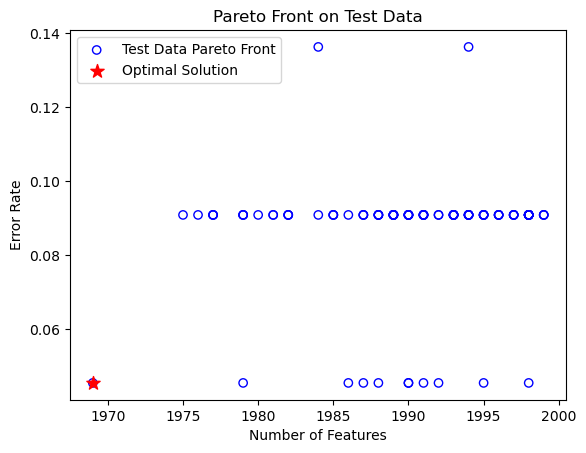

In [16]:
# Plot the Pareto front for test data
import matplotlib.pyplot as plt

plt.scatter(f_test[:, 0], f_test[:, 1], edgecolor="blue", facecolor="none", label="Test Data Pareto Front")
plt.scatter(optimal_solution[0], optimal_solution[1], marker='*', color='red', s=100, label="Optimal Solution")
plt.xlabel('Number of Features')
plt.ylabel('Error Rate')
plt.legend()
plt.title("Pareto Front on Test Data")
plt.show()

In [17]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f_train = scaler.fit_transform(f)
hv_train = ind(f_train)
print("HV of the best pareto front train:" + str(round(hv_train, 2)))

HV of the best pareto front train:1.0


In [18]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f_t = scaler.fit_transform(f_test)
hv_test = ind(f_t)
print("HV of the best pareto front test:" + str(round(hv_test, 2)))

HV of the best pareto front test:1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


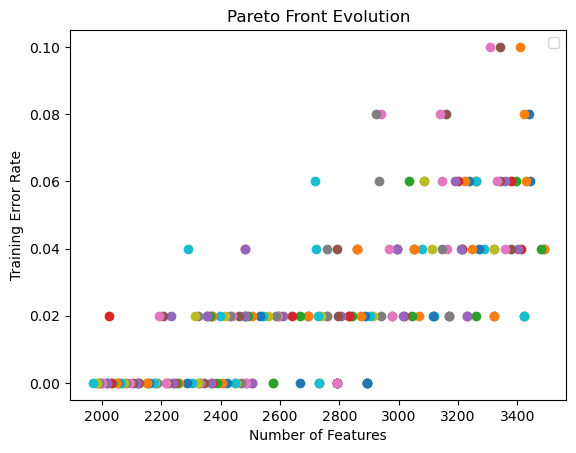

In [19]:
# Extracting and plotting the Pareto Front from all generations
pareto_fronts = [gen.opt.get("F") for gen in res.history]

for i, pareto in enumerate(pareto_fronts):
    plt.scatter(pareto[:, 0], pareto[:, 1])

plt.xlabel('Number of Features')
plt.ylabel('Training Error Rate')
plt.title('Pareto Front Evolution')
plt.legend()
plt.show()



the intial pareto front is plotted as: 


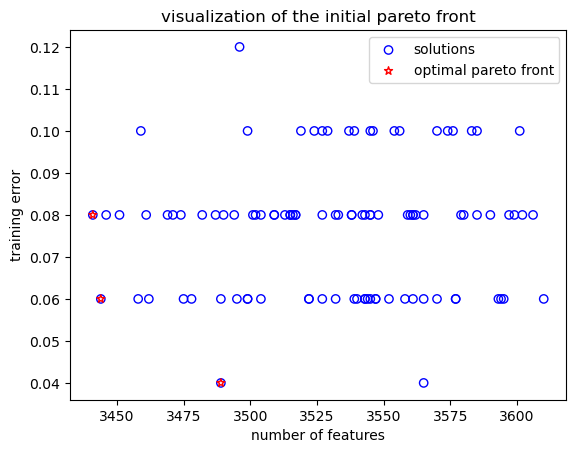

In [20]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()


the final pareto front is plotted as: 


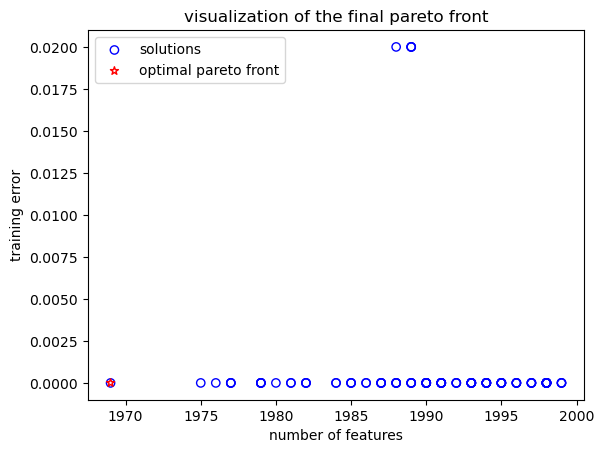

In [21]:
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

the final pareto front is plotted as: 


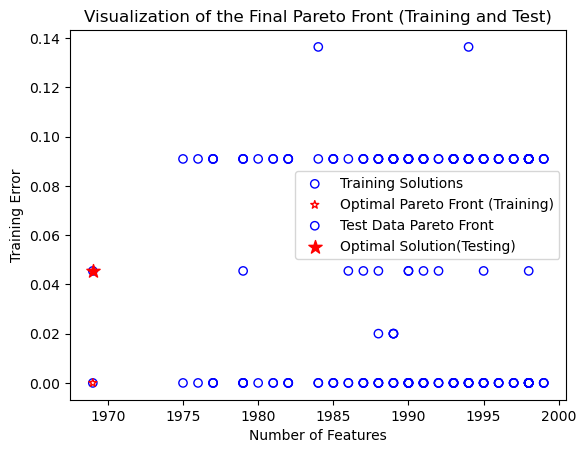

In [22]:
print("the final pareto front is plotted as: ")
#Train data
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label="Training Solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto Front (Training)")
#Test data
plt.scatter(f_test[:, 0], f_test[:, 1], edgecolor="blue", facecolor="none", label="Test Data Pareto Front")
plt.scatter(optimal_solution[0], optimal_solution[1], marker='*', color='red', s=100, label="Optimal Solution(Testing)")

plt.xlabel('Number of Features')
plt.ylabel('Training Error')
plt.legend()
plt.title("Visualization of the Final Pareto Front (Training and Test)")
plt.show()

In [23]:
# Get the minimum error from the optimization result
min_error_train = np.min(res.F[:, 1])

# Print the minimum error
print("Minimum error on training dataset:", min_error_train)

Minimum error on training dataset: 0.0


In [24]:
# Get the minimum error from the optimization result
min_error_test = np.min(f_test[:,1])

# Print the minimum error
print("Minimum error on testing dataset:", min_error_test)

Minimum error on testing dataset: 0.045454545454545414


In [25]:
# Get the minimum error from the optimization result
min_error_train = np.min(res.F[:, 1])

# Find the row(s) where the error is minimized
min_error_indices = np.where(res.F[:, 1] == min_error_train)[0]

# Get the corresponding solutions with minimum error
solutions_with_min_error = res.X[min_error_indices]

# Get the number of features for the solutions with minimum error
num_features_with_min_error_train = [np.count_nonzero(solution) for solution in solutions_with_min_error]

# Print the number of features with minimum error
print("Number of features with minimum error on train:", num_features_with_min_error_train)

Number of features with minimum error on train: [1969]


In [26]:
num_features_with_min_error_test = optimal_solution[0]
print("Number of features with minimum error on test data:",num_features_with_min_error_test)

Number of features with minimum error on test data: 1969.0


In [27]:
from prettytable import PrettyTable

# Create a PrettyTable instance
table = PrettyTable()

# Set the column alignment
table.align = "l"

# Define the column names
table.field_names = ["Info about Dataset", "H.V.(Train)", "H.V.(Test)", 
                     "Min. Error(Train)", "Min. Error(Test)", "Feat. with Min. Error (Train)", 
                     "Feat. with Min. Error (Test)"]

# Populate the table with data
dataset_info = "Colon,62,2000"
hv_training = "{:.2f}".format(hv_train)
hv_testing = "{:.2f}".format(hv_test)
min_error_training = "{:.5f}".format(min_error_train)
min_error_testing = "{:.5f}".format(min_error_test)
min_error_features_training = num_features_with_min_error_train[0]
min_error_features_testing = num_features_with_min_error_test
samplesize = "62"
features = "2000"

# Add data to the table row
table.add_row([dataset_info, hv_training, hv_testing, min_error_training, min_error_testing,
               min_error_features_training, min_error_features_testing])


# Print the table
print(table)


+--------------------+-------------+------------+-------------------+------------------+-------------------------------+------------------------------+
| Info about Dataset | H.V.(Train) | H.V.(Test) | Min. Error(Train) | Min. Error(Test) | Feat. with Min. Error (Train) | Feat. with Min. Error (Test) |
+--------------------+-------------+------------+-------------------+------------------+-------------------------------+------------------------------+
| Colon,62,2000      | 1.00        | 1.00       | 0.00000           | 0.04545          | 1969                          | 1969.0                       |
+--------------------+-------------+------------+-------------------+------------------+-------------------------------+------------------------------+
